In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import manifold
from tslearn.barycenters import softdtw_barycenter
from tslearn.barycenters import euclidean_barycenter
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from scipy import signal
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [3]:
#reading Covid dataset and cleaning the data
df = pd.read_csv(r"Data.csv")
df = df.round(3)
display(df.head())
df = df.drop(['Latitude', 'Longitude', 'Hospital beds per 1000 people', 'Medical doctors per 1000 people',
              'GDP/Capita', 'Median age', 'Population aged 65 and over (%)', 'Average temperature per year', 'Continent', 'Population'], axis=1)

df.rename(columns={'Entity': 'country',
                   'Date' : 'date'}, inplace=True)
df = df.groupby('country').apply(lambda x: x.fillna(method='ffill'))
df = df.groupby('country').apply(lambda x: x.fillna(method='bfill'))
df = df[df.Cases > 0]
display(df.head())

print("COVID Dataset1")
print(f"Earliest Entry: {df['date'].min()}")
print(f"Last Entry:     {df['date'].max()}")

,Entity,Continent,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Date,Daily tests,Cases,Deaths
0,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-25,8.0,NaN,NaN
1,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-26,5.0,NaN,NaN
2,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-27,4.0,NaN,NaN
3,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-28,1.0,NaN,NaN
4,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-29,8.0,NaN,NaN


,country,date,Daily tests,Cases,Deaths
0,Albania,2020-02-25,8.0,2.0,1.0
1,Albania,2020-02-26,5.0,2.0,1.0
2,Albania,2020-02-27,4.0,2.0,1.0
3,Albania,2020-02-28,1.0,2.0,1.0
4,Albania,2020-02-29,8.0,2.0,1.0


COVID Dataset1
Earliest Entry: 2020-01-01
Last Entry:     2021-02-28


In [4]:
#pivot and reindex the data table
covid_df = df.pivot(index="country", columns="date", values = 'Cases')
covid_df = covid_df.fillna(0)
display(covid_df)

date,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,...,2021-02-19,2021-02-20,2021-02-21,2021-02-22,2021-02-23,2021-02-24,2021-02-25,2021-02-26,2021-02-27,2021-02-28
country,,,,,,,,,,,,,,,,,,,,,
Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,97909.0,99062.0,100246.0,101285.0,102306.0,103327.0,104313.0,105229.0,106215.0,107167.0
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,111600.0,111764.0,111917.0,112094.0,112279.0,112461.0,112622.0,112805.0,112960.0,113092.0
Argentina,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2054681.0,2060625.0,2064334.0,2069751.0,2077228.0,2085411.0,2093645.0,2098728.0,2104197.0,2107365.0
Armenia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,170011.0,170234.0,170402.0,170506.0,170672.0,170945.0,171227.0,171510.0,171793.0,172058.0
Australia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28920.0,28926.0,28930.0,28937.0,28939.0,28947.0,28957.0,28965.0,28970.0,28978.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United States,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28006110.0,28077620.0,28134115.0,28190159.0,28261595.0,28336097.0,28413388.0,28490179.0,28554465.0,28605669.0
Uruguay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,51377.0,52163.0,52815.0,53310.0,53973.0,54874.0,55695.0,56542.0,57362.0,57994.0
Vietnam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2362.0,2368.0,2383.0,2392.0,2403.0,2412.0,2421.0,2426.0,2432.0,2448.0


In [5]:
#Reading the second dataset and cleaning it
df_temperature = pd.read_csv("temperature_dataframe_editUS.csv")
display(df_temperature.head())
df_temperature.columns = ["#","id","province","country","lat","long","date","case","fatalities","capital","humidity","sunHour","tempC","windspeedKmph"]

df_temperature['country'] = df_temperature['country'].replace('UK', 'United Kingdom')
df_temperature = df_temperature[["country", "province", "date", "tempC", "humidity"]].reset_index()
df_temperature.rename(columns={"province": "state"}, inplace=True)

df_temperature["date"] = pd.to_datetime(df_temperature['date'], format ="%d,%m,%y")
df_temperature['state'] = df_temperature['state'].fillna('')
display(df_temperature.head())

print("Temperature Dataset2")
print(f"Earliest Entry: {df_temperature['date'].min()}")
print(f"Last Entry:     {df_temperature['date'].max()}")

,0,1,Unnamed: 2,Afghanistan,33,65,"22,01,20",0.1,0.2,Kabul,65.1,8.7,-1,8
0,1,2,NaN,Afghanistan,33.0,65.0,"23,01,20",0,0,Kabul,59.0,8.7,-3.0,8.0
1,2,3,NaN,Afghanistan,33.0,65.0,"24,01,20",0,0,Kabul,71.0,7.1,0.0,7.0
2,3,4,NaN,Afghanistan,33.0,65.0,"25,01,20",0,0,Kabul,79.0,8.7,0.0,7.0
3,4,5,NaN,Afghanistan,33.0,65.0,"26,01,20",0,0,Kabul,64.0,8.7,-1.0,8.0
4,5,6,NaN,Afghanistan,33.0,65.0,"27,01,20",0,0,Kabul,66.0,8.7,-1.0,6.0


,index,country,state,date,tempC,humidity
0,0,Afghanistan,,2020-01-23,-3.0,59.0
1,1,Afghanistan,,2020-01-24,0.0,71.0
2,2,Afghanistan,,2020-01-25,0.0,79.0
3,3,Afghanistan,,2020-01-26,-1.0,64.0
4,4,Afghanistan,,2020-01-27,-1.0,66.0


Temperature Dataset2
Earliest Entry: 2020-01-22 00:00:00
Last Entry:     2020-03-21 00:00:00


In [6]:
#Reading the second dataset and cleaning it
df_humidity = pd.read_csv("temperature_dataframe_editUS.csv")
df_humidity.columns = ["#","id","province","country","lat","long","date","case","fatalities","capital","humidity","sunHour","tempC","windspeedKmph"]

df_humidity['country'] = df_humidity['country'].replace('UK', 'United Kingdom')
df_humidity = df_humidity[["country", "province", "date", "humidity"]].reset_index()
df_humidity.rename(columns={"province": "state"}, inplace=True)

df_humidity["date"] = pd.to_datetime(df_humidity['date'], format ="%d,%m,%y")
df_humidity['state'] = df_humidity['state'].fillna('')
display(df_humidity.head())

print("Temperature Dataset2")
print(f"Earliest Entry: {df_humidity['date'].min()}")
print(f"Last Entry:     {df_humidity['date'].max()}")

,index,country,state,date,humidity
0,0,Afghanistan,,2020-01-23,59.0
1,1,Afghanistan,,2020-01-24,71.0
2,2,Afghanistan,,2020-01-25,79.0
3,3,Afghanistan,,2020-01-26,64.0
4,4,Afghanistan,,2020-01-27,66.0


Temperature Dataset2
Earliest Entry: 2020-01-22 00:00:00
Last Entry:     2020-03-21 00:00:00


In [7]:
#group by temp
avgt = df_temperature.groupby(
    [pd.to_datetime(df_temperature.date).dt.strftime('%b %Y'), 'country']
)['tempC'].mean().reset_index(name='Average temp')
#group by humidity
avgh = df_humidity.groupby(
    [pd.to_datetime(df_temperature.date).dt.strftime('%b %Y'), 'country']
)['humidity'].mean().reset_index(name='Average humidity')
#merge
avgClimate = avgt.merge(avgh, on=['country','date'], how='inner')
#pivoting and reindexing the data
avgClimate_temp_df = avgClimate.pivot(index="country", columns="date")
avgClimate_temp_df

Average temp                       Average humidity             \
date            Feb 2020   Jan 2020   Mar 2020         Feb 2020   Jan 2020   
country                                                                      
Afghanistan     4.689655  -1.444444  11.952381        57.758621  65.555556   
Albania        13.000000  13.100000  15.666667        69.241379  70.800000   
Algeria        19.965517  19.300000  19.142857        61.137931  55.700000   
Andorra         9.034483   2.400000   7.476190        64.379310  91.000000   
Argentina      32.862069  33.900000  32.238095        42.241379  39.000000   
...                  ...        ...        ...              ...        ...   
Uruguay        28.586207  29.100000  28.666667        54.758621  51.300000   
Uzbekistan     12.586207   7.900000  17.619048        54.241379  61.100000   
Venezuela      24.241379  26.200000  24.857143        81.241379  79.400000   
Vietnam        23.379310  20.600000  26.952381        74.448276  68.700000   
Zambia         25.241379  25.500000  24.333333        89.379310  84.900000   

                        
date          Mar 2020  
country                 
Afghanistan  51.714286  
Albania      70.380952  
Algeria      65.380952  
Andorra      82.714286  
Argentina    47.714286  
...                ...  
Uruguay      59.904762  
Uzbekistan   44.714286  
Venezuela    77.190476  
Vietnam      75.190476  
Zambia       86.904762  

[156 rows x 6 columns]

In [8]:
#Group by humidity
avgh = df_humidity.groupby(
    [pd.to_datetime(df_temperature.date).dt.strftime('%b %Y'), 'country']
)['humidity'].mean().reset_index(name='Average humidity')
#pivoting and reindexing the data
avgClimate_df = avgh.pivot(index="country", columns="date")
avgClimate_df

Average humidity                      
date                Feb 2020   Jan 2020   Mar 2020
country                                           
Afghanistan        57.758621  65.555556  51.714286
Albania            69.241379  70.800000  70.380952
Algeria            61.137931  55.700000  65.380952
Andorra            64.379310  91.000000  82.714286
Argentina          42.241379  39.000000  47.714286
...                      ...        ...        ...
Uruguay            54.758621  51.300000  59.904762
Uzbekistan         54.241379  61.100000  44.714286
Venezuela          81.241379  79.400000  77.190476
Vietnam            74.448276  68.700000  75.190476
Zambia             89.379310  84.900000  86.904762

[156 rows x 3 columns]

In [9]:
# Combine both the datasets to get our required data table.
dataset_temp = pd.concat([avgClimate_temp_df, covid_df], axis=1, join="inner")
dataset = dataset_temp.fillna(0)
dataset 
#y = dataset['country']

,"(Average temp, Feb 2020)","(Average temp, Jan 2020)","(Average temp, Mar 2020)","(Average humidity, Feb 2020)","(Average humidity, Jan 2020)","(Average humidity, Mar 2020)",2020-01-01,2020-01-02,2020-01-03,2020-01-04,...,2021-02-19,2021-02-20,2021-02-21,2021-02-22,2021-02-23,2021-02-24,2021-02-25,2021-02-26,2021-02-27,2021-02-28
country,,,,,,,,,,,,,,,,,,,,,
Albania,13.000000,13.1,15.666667,69.241379,70.8,70.380952,0.0,0.0,0.0,0.0,...,97909.0,99062.0,100246.0,101285.0,102306.0,103327.0,104313.0,105229.0,106215.0,107167.0
Algeria,19.965517,19.3,19.142857,61.137931,55.7,65.380952,0.0,0.0,0.0,0.0,...,111600.0,111764.0,111917.0,112094.0,112279.0,112461.0,112622.0,112805.0,112960.0,113092.0
Argentina,32.862069,33.9,32.238095,42.241379,39.0,47.714286,1.0,1.0,1.0,1.0,...,2054681.0,2060625.0,2064334.0,2069751.0,2077228.0,2085411.0,2093645.0,2098728.0,2104197.0,2107365.0
Armenia,3.379310,3.0,14.190476,67.482759,50.3,50.000000,0.0,0.0,0.0,0.0,...,170011.0,170234.0,170402.0,170506.0,170672.0,170945.0,171227.0,171510.0,171793.0,172058.0
Australia,25.896552,33.0,22.190476,65.137931,48.6,70.428571,0.0,0.0,0.0,0.0,...,28920.0,28926.0,28930.0,28937.0,28939.0,28947.0,28957.0,28965.0,28970.0,28978.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ukraine,4.551724,3.2,10.571429,76.448276,84.2,67.428571,0.0,0.0,0.0,0.0,...,1340054.0,1346527.0,1351190.0,1354545.0,1358871.0,1364861.0,1373139.0,1381273.0,1389570.0,1395528.0
United Kingdom,4.551724,3.2,10.571429,76.448276,84.2,67.428571,0.0,0.0,0.0,0.0,...,4107290.0,4117743.0,4127578.0,4138237.0,4146760.0,4156707.0,4166727.0,4175315.0,4182772.0,4188827.0
Uruguay,28.586207,29.1,28.666667,54.758621,51.3,59.904762,0.0,0.0,0.0,0.0,...,51377.0,52163.0,52815.0,53310.0,53973.0,54874.0,55695.0,56542.0,57362.0,57994.0


In [280]:
#divide dataset into train and test
train_df = dataset.sample(frac = 0.80)
test_df = dataset.drop(train_df.index)
dataset_array = train_df.values
dataset_array = dataset_array[:,0:6]

In [281]:
train_df.head()

,"(Average temp, Feb 2020)","(Average temp, Jan 2020)","(Average temp, Mar 2020)","(Average humidity, Feb 2020)","(Average humidity, Jan 2020)","(Average humidity, Mar 2020)",2020-01-01,2020-01-02,2020-01-03,2020-01-04,...,2021-02-19,2021-02-20,2021-02-21,2021-02-22,2021-02-23,2021-02-24,2021-02-25,2021-02-26,2021-02-27,2021-02-28
country,,,,,,,,,,,,,,,,,,,,,
Peru,25.586207,26.1,26.142857,75.620690,74.2,74.095238,0.0,0.0,0.0,0.0,...,1261804.0,1269523.0,1283309.0,1283309.0,1286757.0,1293497.0,1300799.0,1316363.0,1323863.0,1323863.0
Guatemala,26.758621,25.9,28.238095,72.517241,79.6,70.380952,0.0,0.0,0.0,0.0,...,170275.0,170931.0,171170.0,171289.0,172072.0,172764.0,173142.0,173814.0,174335.0,174542.0
Vietnam,23.379310,20.6,26.952381,74.448276,68.7,75.190476,0.0,0.0,0.0,0.0,...,2362.0,2368.0,2383.0,2392.0,2403.0,2412.0,2421.0,2426.0,2432.0,2448.0
Estonia,2.758621,2.8,4.095238,81.551724,85.8,81.952381,0.0,0.0,0.0,0.0,...,56246.0,57033.0,57616.0,58445.0,59407.0,60475.0,61627.0,62830.0,64399.0,65600.0
Zambia,25.241379,25.5,24.333333,89.379310,84.9,86.904762,0.0,0.0,0.0,0.0,...,73203.0,73894.0,74503.0,75027.0,75582.0,76484.0,77171.0,77639.0,78202.0,78534.0


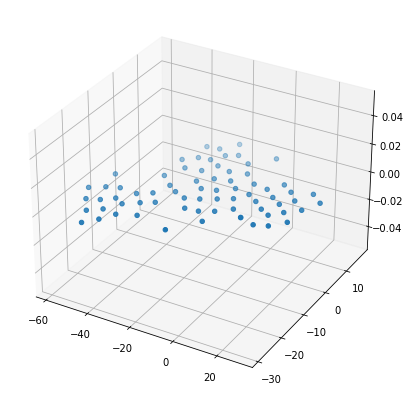

In [283]:
#dimensionality reduction
embedding = manifold.TSNE(n_components= 2, init='pca',random_state=0, perplexity = 30)
train_2d = embedding.fit_transform(dataset_array) 
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(251, projection = '3d')
ax.scatter(train_2d[:, 0], train_2d[:, 1])
ax.axis('tight')
plt.show()

[1 1 1 0 1 0 1 1 2 2 1 1 2 0 0 0 1 1 1 0 1 2 0 0 1 1 1 2 0 2 1 0 2 2 2 2 1
 1 0 0 0 0 0 2 1 0 0 0 2 1 0 2 1 2 2 1 1 0 0 2 1 0 1 2 1 1 2 1 0 0 1 2]


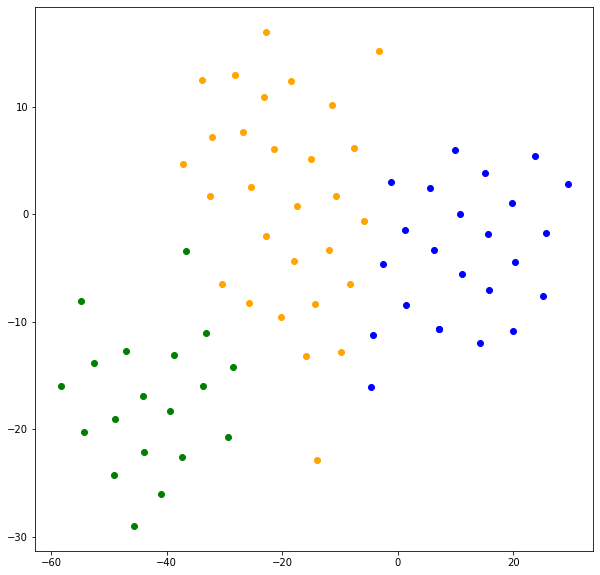

In [284]:
#clustering
k_means = KMeans(n_clusters=3, random_state=0)
kmeans = k_means.fit(train_2d)

labels = kmeans.labels_
print(labels)
colours = ['blue', 'orange', 'green', 'red']
plt.figure(figsize=(10, 10))
count = 0
for i in labels:
    plt.scatter(train_2d[count][0], train_2d[count][1], label = i, color = colours[i])
    count = count +1
#plt.legend()
plt.show()


In [285]:
#concatenation of labels , and country covid cases for aggregation
df_label = pd.DataFrame(labels)
df_index = pd.DataFrame(train_df.index)
df_labels = pd.concat([df_label, df_index], axis=1, join="inner")
df_labels.columns =['cluster_labels', 'country']
df_labels
data_ts = train_df[train_df.columns[6:]]
data_final = pd.merge(df_labels, data_ts, on=["country"])
data_final

,cluster_labels,country,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,...,2021-02-19,2021-02-20,2021-02-21,2021-02-22,2021-02-23,2021-02-24,2021-02-25,2021-02-26,2021-02-27,2021-02-28
0,1,Peru,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1261804.0,1269523.0,1283309.0,1283309.0,1286757.0,1293497.0,1300799.0,1316363.0,1323863.0,1323863.0
1,1,Guatemala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,170275.0,170931.0,171170.0,171289.0,172072.0,172764.0,173142.0,173814.0,174335.0,174542.0
2,1,Vietnam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2362.0,2368.0,2383.0,2392.0,2403.0,2412.0,2421.0,2426.0,2432.0,2448.0
3,0,Estonia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56246.0,57033.0,57616.0,58445.0,59407.0,60475.0,61627.0,62830.0,64399.0,65600.0
4,1,Zambia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,73203.0,73894.0,74503.0,75027.0,75582.0,76484.0,77171.0,77639.0,78202.0,78534.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,1,Kenya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,103841.0,103993.0,104201.0,104306.0,104500.0,104780.0,105057.0,105467.0,105648.0,105973.0
68,0,United Kingdom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4107290.0,4117743.0,4127578.0,4138237.0,4146760.0,4156707.0,4166727.0,4175315.0,4182772.0,4188827.0
69,0,Switzerland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,547775.0,547775.0,547775.0,550224.0,551355.0,552698.0,553867.0,554932.0,554932.0,554932.0
70,1,Serbia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,431680.0,434122.0,436640.0,439596.0,442853.0,446313.0,449901.0,453240.0,456450.0,459259.0


In [286]:
def moving_average(signal, period):
    buffer = []
    for i in range(period, len(signal)):
        buffer.append(np.array(signal[i - period : i]).mean())
    return buffer

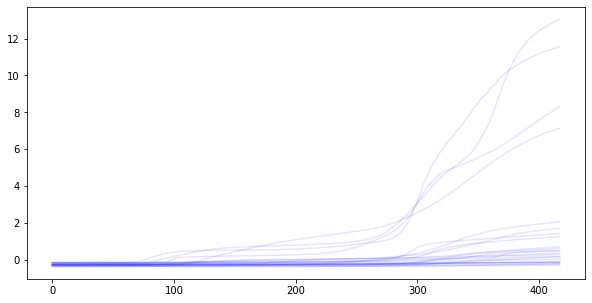

In [287]:
#Prepocessing of cluster 0 data
cluster_0 = data_final[data_final['cluster_labels']==0]
cluster_0 = cluster_0[cluster_0.columns[4:]]
x, y = cluster_0.shape
plt.figure(figsize=(10, 5))

arr_0 = cluster_0.to_numpy()
#print(arr_0[1])
for i in range(len(arr_0)):
    arr_0[i] = (arr_0[i]- np.mean(arr_0))/np.std(arr_0) #Amplitude Scaling
#moving Average
arr_0_processed =  []
for val in range(len(arr_0)):
    arr_0_processed.append(moving_average(arr_0[val], 5))
    
#Plot it on the graph
arr_0_processed = np.array(arr_0_processed)

for series in arr_0_processed:
        plt.plot(series.ravel(), "b", alpha=.1)

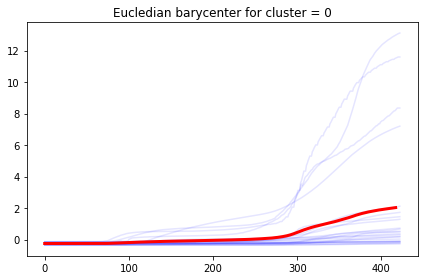

In [288]:
# Dtw aggregation of time series with cluster 0
length_of_sequence = cluster_0.shape[1]

def plot_helper(barycenter):
    # plot all points of the data set
    for series in arr_0:
        plt.plot(series.ravel(), "b", alpha=.1)
    # plot the given barycenter of them
    plt.plot(barycenter.ravel(), "r", linewidth=3)

ax1 = plt.subplot(4, 1, 1)
plt.subplot(1, 1, 1, sharex=ax1)
plt.title("Eucledian barycenter for cluster = 0")
# aggregated Time series
cluster0_aggregated_timeseries =  euclidean_barycenter(arr_0_processed)
plot_helper( euclidean_barycenter(arr_0_processed))

# clip the axes for better readability
ax1.set_xlim([0, length_of_sequence])
# show the plot(s)
plt.tight_layout()
plt.show()

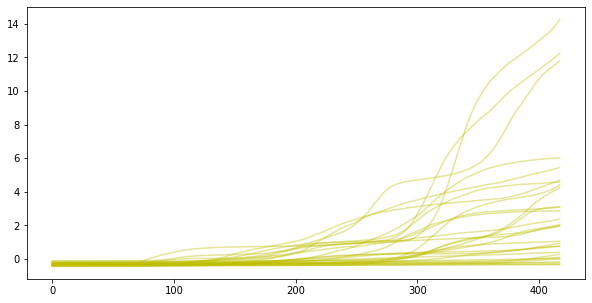

In [289]:
#Prepocessing of cluster 1 data
cluster_1 = data_final[data_final['cluster_labels']==1]
cluster_1 = cluster_1[cluster_1.columns[4:]]
x, y = cluster_1.shape
plt.figure(figsize=(10, 5))

arr_1 = cluster_1.to_numpy()
#Amplitude transformation
for i in range(len(arr_1)):
    arr_1[i] = (arr_1[i]- np.mean(arr_1))/np.std(arr_1) #Amplitude Scaling
#moving Average
arr_1_processed =  []
for val in range(len(arr_1)):
    arr_1_processed.append(moving_average(arr_1[val], 5))
    
#Plot it on the graph
arr_1_processed = np.array(arr_1_processed)
for series in arr_1_processed:
        plt.plot(series.ravel(), "y", alpha = .4)

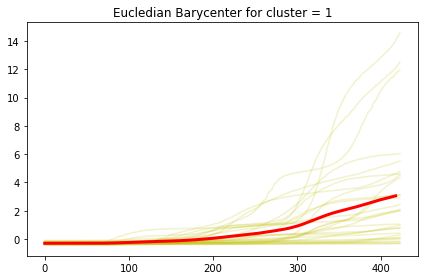

In [290]:
# Dtw aggregation of time series with cluster 1
length_of_sequence = cluster_1.shape[1]

def plot_helper(barycenter):
    # plot all points of the data set
    for series in arr_1:
        plt.plot(series.ravel(), "y", alpha=.2)
    # plot the given barycenter of them
    plt.plot(barycenter.ravel(), "r-", linewidth=3)

ax1 = plt.subplot(4, 1, 1)
plt.subplot(1, 1, 1, sharex=ax1)
plt.title("Eucledian Barycenter for cluster = 1")
# aggregated Time series
cluster1_aggregated_timeseries = euclidean_barycenter(arr_1_processed)
plot_helper(euclidean_barycenter(arr_1_processed))

# clip the axes for better readability
ax1.set_xlim([0, length_of_sequence])
# show the plot(s)
plt.tight_layout()
plt.show()

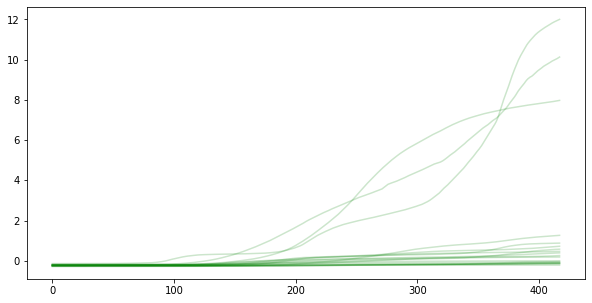

In [291]:
#Prepocessing of cluster 2 data
cluster_2 = data_final[data_final['cluster_labels']==2]
cluster_2 = cluster_2[cluster_2.columns[4:]]
x, y = cluster_2.shape
arr_2 = cluster_2.to_numpy()   

plt.figure(figsize=(10,5))
#Amplitude transformation
for i in range(len(arr_2)):
    arr_2[i] = (arr_2[i]- np.mean(arr_2))/np.std(arr_2) #Amplitude Scaling
#moving Average
arr_2_processed =  []
for val in range(len(arr_2)):
    arr_2_processed.append(moving_average(arr_2[val], 5))
    
#Plot it on the graph
arr_2_processed = np.array(arr_2_processed)
for series in arr_2_processed:
        plt.plot(series.ravel(), "g", alpha = .2)


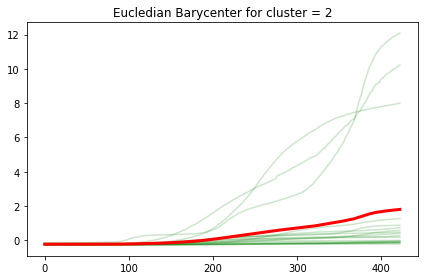

In [292]:
# Dtw aggregation of time series with cluster 2
length_of_sequence = cluster_2.shape[1]

def plot_helper(barycenter):
    # plot all points of the data set
    for series in arr_2:
        plt.plot(series.ravel(), "g", alpha=.2)
    # plot the given barycenter of them
    plt.plot(barycenter.ravel(), "r-", linewidth=3)

ax1 = plt.subplot(4, 1, 1)
plt.subplot(1, 1, 1, sharex=ax1)
plt.title("Eucledian Barycenter for cluster = 2")
cluster2_aggregated_timeseries = euclidean_barycenter(arr_2)
plot_helper(euclidean_barycenter(arr_2))

# clip the axes for better readability
ax1.set_xlim([0, length_of_sequence])
# show the plot(s)
plt.tight_layout()
plt.show()

In [293]:
# testing

In [294]:
#Preprocessing of test data
dataset_array_test = test_df.values
dataset_array_test = dataset_array_test[:,0:6]
embedding = manifold.TSNE(n_components= 2, init='pca',random_state=0, perplexity = 30)
test_2d = embedding.fit_transform(dataset_array_test) 

In [295]:
# identify the cluster to whch it belongs to
cluster_centers = kmeans.cluster_centers_
predictions = k_means.predict(test_2d, sample_weight=None)
predictions

array([0, 0, 2, 0, 1, 2, 2, 0, 2, 1, 2, 0, 0, 0, 2, 2, 0, 2], dtype=int32)

In [296]:
#concatenation of labels , and country covid cases for aggregation
df_label = pd.DataFrame(predictions)
df_index = pd.DataFrame(test_df.index)
df_labels = pd.concat([df_label, df_index], axis=1, join="inner")
df_labels.columns =['cluster_predictions', 'country']
df_labels
data_ts = test_df[test_df.columns[6:]]
data_final_test = pd.merge(df_labels, data_ts, on=["country"])
data_final_test

,cluster_predictions,country,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,...,2021-02-19,2021-02-20,2021-02-21,2021-02-22,2021-02-23,2021-02-24,2021-02-25,2021-02-26,2021-02-27,2021-02-28
0,0,Colombia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2217001.0,2222018.0,2226262.0,2229663.0,2233589.0,2237542.0,2241225.0,2244792.0,2248135.0,2251690.0
1,0,Croatia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,239254.0,239685.0,239945.0,240017.0,240360.0,241048.0,241592.0,242097.0,242617.0,242973.0
2,2,Cyprus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33046.0,33153.0,33260.0,33391.0,33567.0,33710.0,33909.0,34181.0,34424.0,34707.0
3,0,Iceland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6045.0,6045.0,6045.0,6049.0,6049.0,6049.0,6049.0,6049.0,6049.0,6049.0
4,1,Indonesia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1263299.0,1271353.0,1278653.0,1288833.0,1298608.0,1306141.0,1314634.0,1322866.0,1329074.0,1334634.0
5,2,Iran,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1558159.0,1566081.0,1574012.0,1582275.0,1590605.0,1598875.0,1607081.0,1615184.0,1623159.0,1631169.0
6,2,Pakistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,569846.0,571174.0,572334.0,573384.0,574580.0,575941.0,577482.0,578797.0,579973.0,581365.0
7,0,Panama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,335339.0,336037.0,336521.0,337087.0,337805.0,338701.0,339383.0,339781.0,340445.0,340915.0
8,2,Poland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1623218.0,1631727.0,1638767.0,1642658.0,1648962.0,1661109.0,1673252.0,1684788.0,1696885.0,1706986.0
9,1,Romania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,774555.0,777276.0,779695.0,781329.0,784711.0,788048.0,791971.0,795732.0,799164.0,801994.0


In [297]:
# Qualitative Analysis

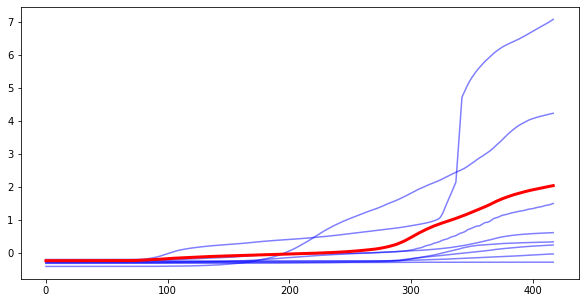

In [298]:
#test for cluster 0
#Prepocessing of cluster 0 test data
cluster_0_test = data_final_test[data_final_test['cluster_predictions']==0]
cluster_0_test = cluster_0_test[cluster_0_test.columns[4:]]
x, y = cluster_0_test.shape
arr_0_test = cluster_0_test.to_numpy()
plt.figure(figsize=(10,5))
#Amplitude transformation
for i in range(len(arr_0_test)):
    arr_0_test[i] = (arr_0_test[i]- np.mean(arr_0_test))/np.std(arr_0_test) #Amplitude Scaling
#moving Average
arr_0_test_processed =  []
for val in range(len(arr_0_test)):
    arr_0_test_processed.append(moving_average(arr_0_test[val], 5))
    
#Plot it on the graph
arr_0_test_processed = np.array(arr_0_test_processed)
for series in arr_0_test_processed:
        plt.plot(series.ravel(), "b", alpha = .5)


plt.plot(cluster0_aggregated_timeseries.ravel(), "r-", linewidth=3)

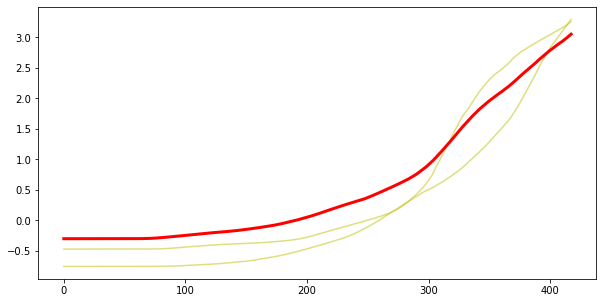

In [299]:
#test for cluster 1
#Prepocessing of cluster 1 test data
cluster_1_test = data_final_test[data_final_test['cluster_predictions']==1]
cluster_1_test = cluster_1_test[cluster_1_test.columns[4:]]
x, y = cluster_1_test.shape
   
arr_1_test = cluster_1_test.to_numpy()
plt.figure(figsize=(10,5))
#Amplitude transformation
for i in range(len(arr_1_test)):
    arr_1_test[i] = (arr_1_test[i]- np.mean(arr_1_test))/np.std(arr_1_test) #Amplitude Scaling
#moving Average
arr_1_test_processed =  []
for val in range(len(arr_1_test)):
    arr_1_test_processed.append(moving_average(arr_1_test[val], 5))
    
#Plot it on the graph
arr_1_test_processed = np.array(arr_1_test_processed)
for series in arr_1_test_processed:
        plt.plot(series.ravel(), "y", alpha = .5)
        
        
plt.plot(cluster1_aggregated_timeseries.ravel(), "r-", linewidth=3)

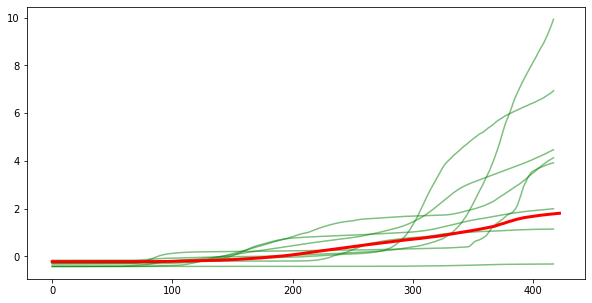

In [300]:
#test for cluster 2
#Prepocessing of cluster 2 test data
cluster_2_test = data_final_test[data_final_test['cluster_predictions']==2]
cluster_2_test = cluster_2_test[cluster_2_test.columns[4:]]
x, y = cluster_2_test.shape    
arr_2_test = cluster_2_test.to_numpy()
plt.figure(figsize=(10,5))
#Amplitude transformation
for i in range(len(arr_2_test)):
    arr_2_test[i] = (arr_2_test[i]- np.mean(arr_2_test))/np.std(arr_2_test) #Amplitude Scaling
#moving Average
arr_2_test_processed =  []
for val in range(len(arr_2_test)):
    arr_2_test_processed.append(moving_average(arr_2_test[val], 5))
    
#Plot it on the graph
arr_2_test_processed = np.array(arr_2_test_processed)
for series in arr_2_test_processed:
        plt.plot(series.ravel(), "g", alpha = .5)
        
plt.plot(cluster2_aggregated_timeseries.ravel(), "r-", linewidth=3)

In [301]:
#Quantitative Analysis
#Cluster 0
dist1 = []
for arr in arr_0_test:
    distance = dtw.distance(arr, cluster0_aggregated_timeseries)
    (dist1.append(distance))
#print(dist)
if len(dist1)==0:
    avg1 = 0
else:
    avg1 = sum(dist1)/len(dist1)
print(avg1)

15.55489514460902


In [302]:
#Cluster 1
dist2 = []
for arr in arr_1_test:
    distance = dtw.distance(arr, cluster1_aggregated_timeseries)
    (dist2.append(distance)) #Scale down all the values
#print(dist)
avg2 = sum(dist2)/len(dist2) 
print(avg2)

3.9201935465995175


In [303]:
#Cluster 2
dist3 = []
for arr in arr_2_test:
    distance = dtw.distance(arr, cluster2_aggregated_timeseries)
    (dist3.append(distance)) #Scale down all the values
#print(dist)
if len(dist3)==0:
    avg3 = 0
else:
    avg3 = sum(dist3)/len(dist3)
print(avg3)

18.21589375675424


In [304]:
#Cumulative Average
avg = (avg1+avg2+avg3)/3
print(avg)

12.563660815987594
